In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [7]:
def wrangle(file):
    try:
        #read file into dataframe
        df = pd.read_csv(file)
        #collinear and high_cardinal features
        cols_to_drop = ['Data.Temperature.Max Temp', 'Data.Temperature.Min Temp', 'Data.Wind.Direction','Date.Month', 'Date.Week of', 'Date.Year']
        #drop collinear and high_cardinal features
        df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
        #drop categorical features
        df.drop(columns=(df.select_dtypes('object').columns), inplace=True)  
        #rename columns for readability
        column_dict = {
            'Data.Precipitation':'precipitation',
            'Data.Temperature.Avg Temp': 'temperature',
            'Data.Wind.Speed': 'wind'
        } 
        
        df.rename(columns=column_dict, inplace=True)
        #reorder columns
        df = df[['wind', 'temperature', 'precipitation']]

        #remove wind outliers
        #low, high = df['wind'].quantile([0.06,0.98])#iqr*1.5
        #mask_wind = df['wind'].between(low,high)

        #remove temp outliers
        #low_1, high_1 = df['temperature'].quantile([0.00165,1.0])#iqr*1.5
        #mask_temp = df['temperature'].between(low_1, high_1)

        #remove prec outliers

        #low_2, high_2 = df['precipitation'].quantile([0.82,0.923])#iqr*1.5
        #mask_prec = df['precipitation'].between(low_2, high_2)


        #df = df[mask_wind & mask_temp & mask_prec]


        return df
        
    except FileNotFoundError:
        print(f"Error: The file '{file}' was not found.")

In [8]:
df = wrangle('weather.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16743 entries, 0 to 16742
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wind           16743 non-null  float64
 1   temperature    16743 non-null  int64  
 2   precipitation  16743 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 392.5 KB


In [9]:
df.columns

Index(['wind', 'temperature', 'precipitation'], dtype='object')

In [10]:
#Is there a relationship between wind speed and precipitation? is precipitation dependent on wind speed


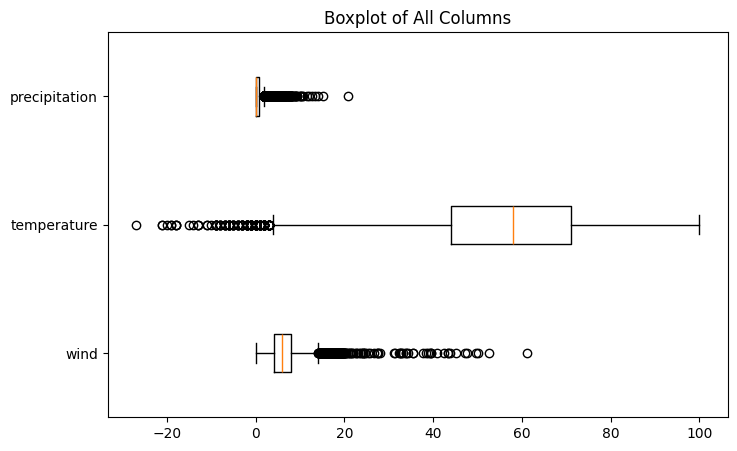

In [11]:
#visualize variables with boxplot
def plot_box(file):
    #get columns
    cols = file.columns
    #set fig size
    fig, ax = plt.subplots(figsize=(8,5))
    #loop through columns
    ax.boxplot([file[col] for col in cols], vert=False, tick_labels=file.columns)
    #ax.set_xlabel(df[col].name)
    ax.set_title('Boxplot of All Columns')
    #show figure
    plt.show();

#call figure
figure = plot_box(df)

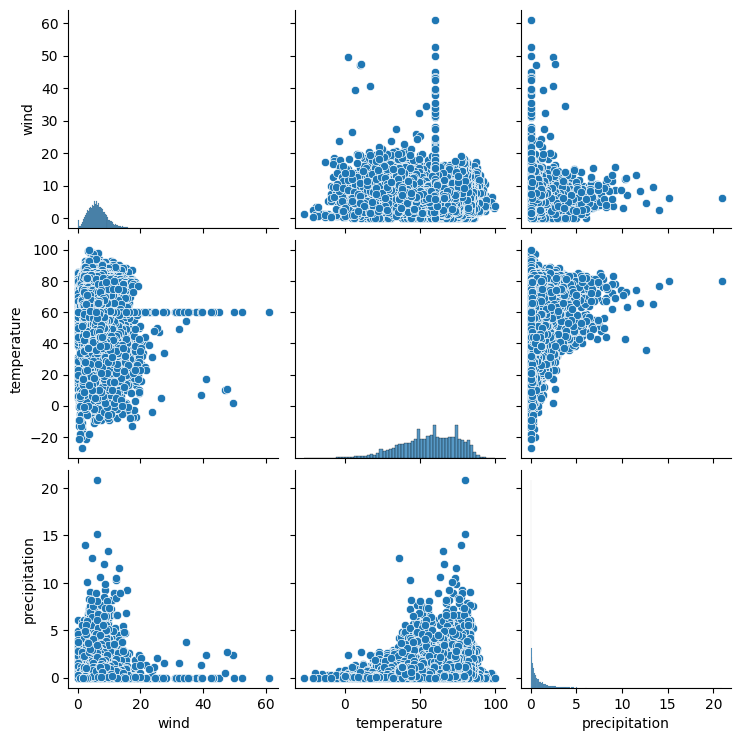

In [12]:
#check collinearity
#pairwise plot with seaborn
sns.pairplot(
    df,
    kind='scatter'
   
);

In [13]:
#get correlation
df.corr()

,wind,temperature,precipitation
wind,1.000000,-0.16233,-0.003102
temperature,-0.162330,1.00000,0.121750
precipitation,-0.003102,0.12175,1.000000


In [14]:
#Baseline mae

x = df.drop('precipitation', axis=1)
y = df['precipitation']
x_train,x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print('y_mean:', y_mean)
print('Baseline MAE:', mae_baseline)



y_mean: 0.5784649843213379
Baseline MAE: 0.6291338186077894


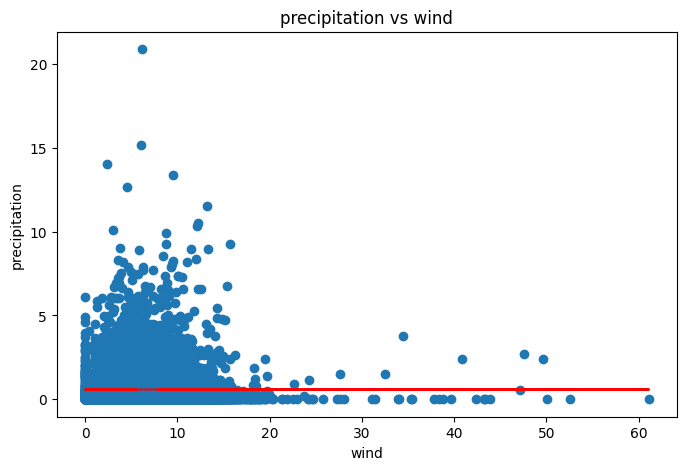

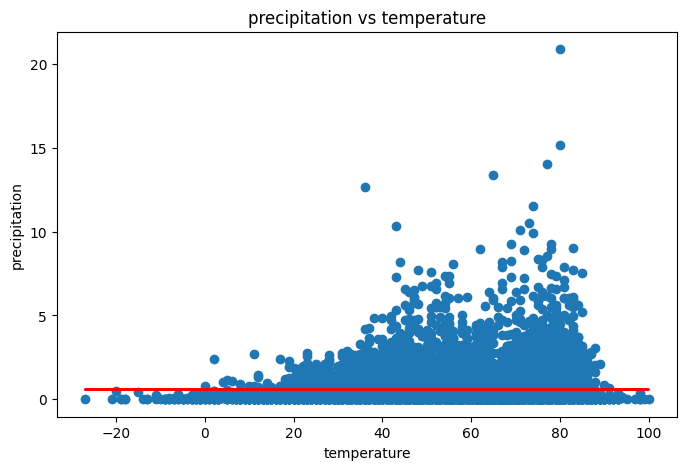

In [15]:
#visualize baseline model
predictors = x_train.columns
for predictor in predictors:
    fig,ax = plt.subplots(figsize=(8,5))
    ax.scatter(x_train[predictor],y_train)
    ax.plot(x_train[predictor], y_pred_baseline, color='red')
    ax.set_xlabel(x_train[predictor].name)
    ax.set_ylabel(y_train.name)
    ax.set_title(f'{y_train.name} vs {x_train[predictor].name}')
    plt.show();


In [16]:
def train(file):
    
    for col in file.columns:
        i = df[col]
        print(i.head())

columns = train(x_train)
columns

0    4.33
1    3.86
2    9.73
3    6.86
4    7.80
Name: wind, dtype: float64
0    39
1    39
2    46
3    45
4    34
Name: temperature, dtype: int64


In [17]:
def univariate_model(data, target):

    cols = data.columns.drop(target)
    results = []

    for feature in cols:
        x = data[[feature]]
        y = data[target]

        x_train,x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
      
        #instantiate model

        model = LinearRegression()

        #fit model
        model.fit(x_train, y_train)

        #training mae
        y_pred_training = model.predict(x_train)
        training_mae = mean_absolute_error(y_train, y_pred_training)
        train_score = model.score(x_train, y_train)
        

        #test_mae
        y_pred_testing = model.predict(x_test)
        testing_mae = mean_absolute_error(y_test, y_pred_testing)
        test_score = model.score(x_test, y_test)
        
        results.append([feature, training_mae, train_score, testing_mae, test_score])
        
    return pd.DataFrame(results, columns =['Feature', 'Training MAE', 'Train Score (R2)','Testing MAE', 'Test Score (R2)'])

    




In [18]:
lreg = univariate_model(df,'precipitation')
lreg
#univariate analysis
#both variables perform similarly
#temperature performs better on training but poorly on testing compared to wind

,Feature,Training MAE,Train Score (R2),Testing MAE,Test Score (R2)
0,wind,0.629120,0.000001,0.625814,0.000014
1,temperature,0.624295,0.014086,0.619943,0.018187


In [19]:
def multivariate_model(data, target):
    
    results = []

    #get features and target
    X = data.drop(target, axis=1)
    y = data[target]
   
    
    #split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)
    
    #instantiate model
    model = LinearRegression()
    
    #fit model
    model.fit(X_train, y_train)
    
    #training mse
    y_pred_training= model.predict(X_train)
    training_mse = mean_absolute_error(y_train, y_pred_training)
    train_score = model.score(X_train, y_train)
    #testing mse
    y_pred_testing = model.predict(X_test)
    testing_mse = mean_absolute_error(y_test, y_pred_testing)
    test_score = model.score(X_test, y_test)
    #retrieve results
    results.append([training_mse, train_score, testing_mse, test_score])
   
    return pd.DataFrame(results, columns=['Training MSE', 'Train Score', 'Testing MSE', 'Test Score'])


In [20]:
multreg = multivariate_model(df, 'precipitation')
multreg

,Training MSE,Train Score,Testing MSE,Test Score
0,0.624346,0.014454,0.620063,0.018058
